In [1]:
# Here is a classical max cut QAOA inspired from:
#  https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained
#  https://qiskit.org/textbook/ch-applications/qaoa.html
#  https://lucaman99.github.io/new_blog/2020/mar16.html

In [4]:
import networkx as nx
import numpy as np

from matplotlib import pyplot as plt

from scipy.optimize import minimize

In [5]:
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

import warnings
warnings.filterwarnings('ignore')

Number of nodes :  4
Nodes colors: 
 ['r', 'r', 'r', 'r']
Weight matrix: 
 [[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]
#######################################################################################


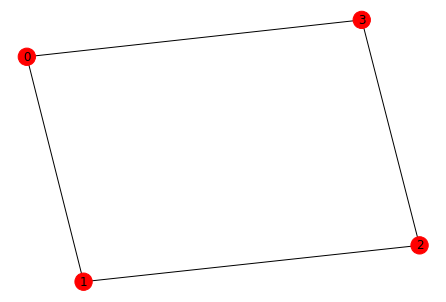

In [46]:

#Example:#
elist=[(0, 1,1.0), (0, 3,1.0), (1, 2,1.0), (2, 3,1.0)] #[(0, 1,1), (1, 2,1), (2, 0,1), (2, 3,1)]#[(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]#[(0,1,1.0),(1,2,1.0),(2,3,1.0)]
G1=Graph(4,elist)

print("Number of nodes : ",G1.nr_nodes)
print("Nodes colors: \n",G1.colors)
print("Weight matrix: \n",G1.W)
print("#######################################################################################")
nx.draw(G1.G,node_color=G1.colors,with_labels=True)

In [47]:
#brut force  for verification  :
def brut_MaxCut(Gr):
    best_cost_brute=0
    max_str=[]
    maxim=0
    for b in range(2**Gr.nr_nodes):
        x=[int(t) for t in reversed(list(bin(b)[2:].zfill(Gr.nr_nodes)))]
        cost=0
        for i in range(Gr.nr_nodes):
            for j in range(Gr.nr_nodes):
                cost=cost+Gr.W[i,j]*x[i]*(1-x[j])

        
        if best_cost_brute==cost:
            max_str.append(str(x))
            
        if best_cost_brute<cost:
            best_cost_brute=cost
            max_str=[]
            max_str.append(str(x))
 
            
    return  max_str, best_cost_brute
            
#Example:#      
max_str, best_cost= brut_MaxCut(G1)  
print("Best cut (cost={}): \n ".format(best_cost))
for i in max_str:
    print(i)

Best cut (cost=4.0): 
 
[1, 0, 1, 0]
[0, 1, 0, 1]


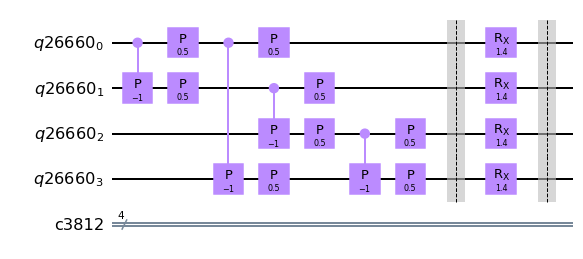

In [48]:
def HC_01(qc,qr,gamma,W):
    
    W=W*gamma
    for i in range(len(qr)):
        for j in range(i+1,len(qr)):
            if W[i][j]!=0:
                qc.cp(-2*W[i,j],qr[i],qr[j])
                qc.p(W[i,j],qr[i])
                qc.p(W[i,j],qr[j])
                
    qc.barrier()

def HB_01(qc,qr,beta):
    
    for i in range(len(qr)):
        qc.rx(2*beta,qr[i])
    qc.barrier()


#Example:#   
qr=QuantumRegister(G1.nr_nodes)
cr=ClassicalRegister(G1.nr_nodes)
qc=QuantumCircuit(qr,cr)

HC_01(qc,qr,0.5,G1.W)
HB_01(qc,qr,0.7)

qc.draw('mpl')

In [49]:
def Init_H(qc,qr):
    for i in range(int(len(qr))):
        qc.h(qr[i])
    qc.barrier()

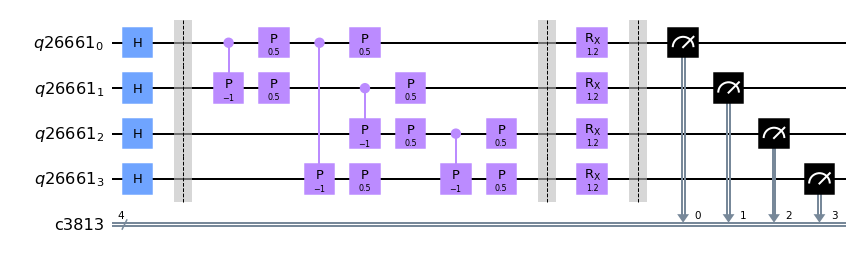

In [50]:
def QAOA_circ_01(Gr,params,l=1):
    
    qr=QuantumRegister(Gr.nr_nodes)
    cr=ClassicalRegister(Gr.nr_nodes)
    qc_QAOA=QuantumCircuit(qr,cr)
    
    Init_H(qc_QAOA,qr)
    for i in range(l):
        HC_01(qc_QAOA,qr,params[i*2],Gr.W)
        HB_01(qc_QAOA,qr,params[i*2+1])
    
    for i in range(Gr.nr_nodes):
        qc_QAOA.measure(qr[i],cr[i])
    return qc_QAOA

#Example:# 
QAOA_circ=QAOA_circ_01(G1,[0.5,0.6],l=1)
QAOA_circ.draw('mpl') 

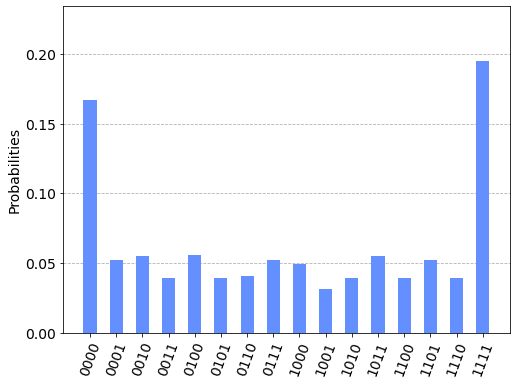

In [51]:
backend=Aer.get_backend("qasm_simulator")
shots=1000

simulate=execute(QAOA_circ, backend=backend, shots=shots)
counts=simulate.result().get_counts()
plot_histogram(counts,figsize = (8,6),bar_labels = False)

In [52]:
def expected_01(counts,Gr,shots):
    cost=0
    for x in counts:
        for i in range (Gr.nr_nodes):
            for j in range(i+1,Gr.nr_nodes):
                if x[i]!=x[j]:
                    cost=cost-Gr.W[i][j]*counts[x]
    cost=cost/shots
    return cost

#Example:# 
cost=expected_01(counts,G1,shots)
print(cost)

-1.432


In [53]:

s=0
for i in counts:
    s=s+counts[i]
print(s)
print(shots)

1000
1000


In [54]:
def QAOA_cost(params,Gr,l=1,
              backend=Aer.get_backend("qasm_simulator"),shots=1000):
    
    qc_QAOA=QAOA_circ_01(Gr,params,l=1)
    counts=execute(qc_QAOA, backend=backend, shots=shots).result().get_counts()
    cost=expected_01(counts,Gr,shots)
    return cost

#Example:#
cost=QAOA_cost([0.5,0.6],G1,l=1,
                backend=Aer.get_backend("qasm_simulator"),shots=1000)
print(cost)

-1.45


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.662
            Iterations: 34
            Function evaluations: 579
            Gradient evaluations: 34
QAOA solutions:
('0101', 1632)
('1010', 1606)

 Clasic solutions:
Best cut (cost=4.0): 
- [1, 0, 1, 0]
- [0, 1, 0, 1]

 Parameters: [-2489370.97092132 -1002635.69722751   952328.97133849  3655122.32821733
  -927412.9867543    488514.39196413]
Quantum state cost -3.226


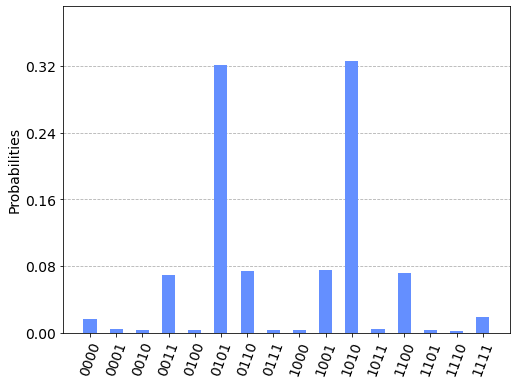

In [57]:
def MaxCut_01(G1,l=1,params=[0.5,0.3],nr_s=2,shots=5000,method='COBYLA'):
    
    optim=minimize(QAOA_cost, params ,args=(G1,l),method=method, 
                   options={'rhobeg': 1.0, 'maxiter': 2000, 
                            'disp': True, 'catol': 0.0002})
    QAOA_circ=QAOA_circ_01(G1,optim.x,l=l)
    counts=execute(QAOA_circ, backend=backend, shots=shots).result().get_counts()
    counts=dict(reversed(sorted(counts.items(), key=lambda item: item[1])))
    
    o=0
    sol=[]
    for i in counts:
        sol.append((i[::-1],counts[i]))
        if len(sol)==nr_s:
            break
            
    return optim.x,counts,sol

#Example:#
para,counts, sol = MaxCut_01(G1,params=[0.5,0.3,0.5,0.3,0.7,0.2],l=3,method='SLSQP')


print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(G1)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)
    
print("\n Parameters:",para)  
print("Quantum state cost",expected_01(counts,G1,shots=5000))
plot_histogram(counts,figsize = (8,6),bar_labels = False)



QAOA solutions:
('0101', 1207)
('1010', 1186)

 Clasic solutions:
Best cut (cost=4.0): 
- [1, 0, 1, 0]
- [0, 1, 0, 1]

 Parameters: [ 2.51714244  2.01948968 -0.31068247 -0.05448555  0.63658896 -0.08664186]
Quantum state cost -2.942


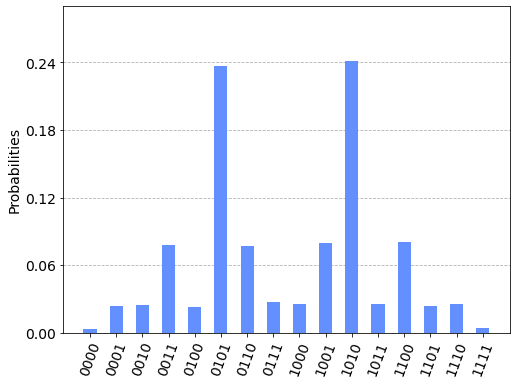

In [41]:
#Test1#

elist=[(0,1,1.0),(1,2,1.0),(2,3,1.0),(3,0,1)]
G2=Graph(4,elist)

para,counts, sol = MaxCut_01(G2,params=[0.5,0.3,0.5,0.3,0.5,0.3],l=3,shots=5000)

print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(G2)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)
    
print("\n Parameters:",para) 
print("Quantum state cost",expected_01(counts,G2,shots=5000))
plot_histogram(counts,figsize = (8,6),bar_labels = False)

QAOA solutions:
('11100', 590)
('00011', 559)

 Clasic solutions:
Best cut (cost=24.0): 
- [0, 0, 1, 1, 0]
- [1, 1, 0, 0, 1]

 Parameters: [2.17759733 2.05638017]
Quantum state cost -16.6052


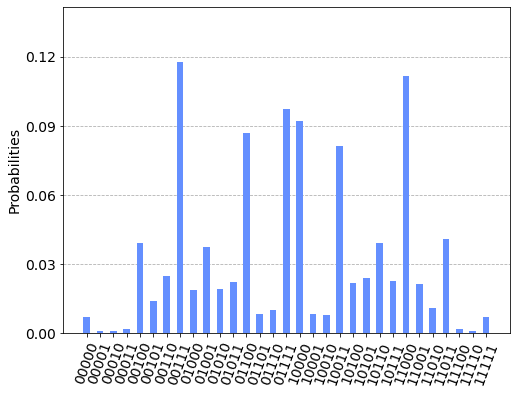

In [29]:
#Test1#

elist=[(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]
G2=Graph(5,elist)

para,counts, sol = MaxCut_01(G2,l=1,shots=5000)

print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(G2)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)
    
print("\n Parameters:",para) 
print("Quantum state cost",expected_01(counts,G2,shots=5000))
plot_histogram(counts,figsize = (8,6),bar_labels = False)

QAOA solutions:
('101100', 364)
('010011', 349)
('011100', 348)
('100010', 336)

 Clasic solutions:
Best cut (cost=24.0): 
- [0, 0, 1, 1, 0, 0]
- [1, 1, 0, 0, 1, 0]
- [0, 0, 1, 1, 0, 1]
- [1, 1, 0, 0, 1, 1]

 Parameters: [2.49757021 2.0526597 ]
Quantum state cost -16.5436


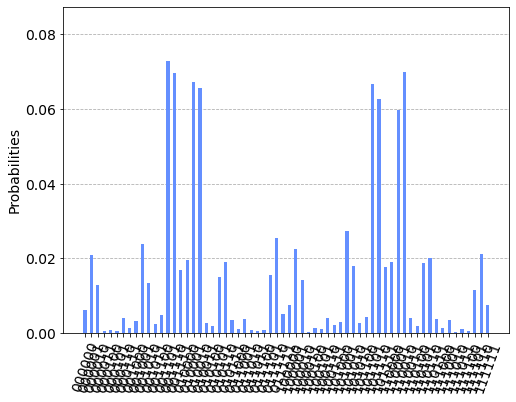

In [17]:
#Test3#

elist=[(5,0,9.0),(0,1,3.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]#[(0,1,1.0),(1,2,1.0),(2,3,1.0)]
G3=Graph(6,elist)

para,counts, sol = MaxCut_01(G3,l=1,nr_s=4,shots=5000)

print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(G3)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)
    
print("\n Parameters:",para) 
print("Quantum state cost",expected_01(counts,G2,shots=5000))
plot_histogram(counts,figsize = (8,6),bar_labels = False)